# <u> Implementing Logistic Regression </u>

In [1]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

## Abstract

Link to source code ([logistic.py](https://github.com/lfschweitzer/lfschweitzer.github.io/blob/23d98daa9a6f335274641d964a13be5ba28f66f9/posts/post5/logistic.py))

For this blog post I implemented logistic regression and performed several experiments on my model. The first experiment I conducted was to see vanilla gradient descent. Vanilla gradient descent is when beta=0 and we were able to know that the model works because we saw loss decrease monotonically. The second experiment was to understand the benefits of momentum. By increasing the beta value we were able to see loss decrease faster than the vanilla gradient descent case. Then, finally, we conducted an experiment to see the potential harms of overfitting our data. By reaching 100% accuracy on training data, we could see the drawback directly by a lower accuracy rate on training data. Overall, I was able to learn more about implementing machine learning models and how to test their functionality. I was able to concretely understand the benefits of momentum and the drawbacks of overfitting.

## Experiments

Before doing any experiments, I had to generate data for a classification problem.

In [2]:
import torch

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

Plot the data

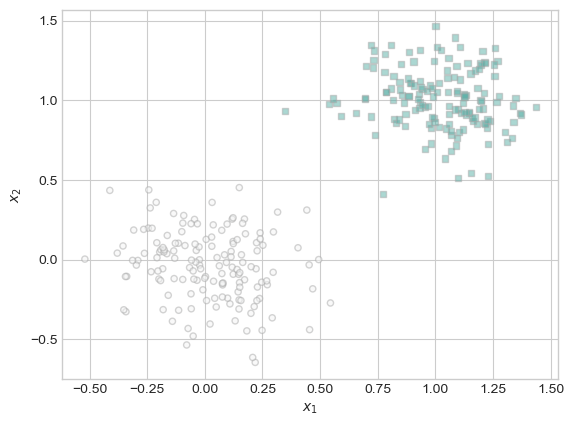

In [3]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def plot_classification_data(X, y, ax):
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    
    
fig, ax = plt.subplots(1, 1)

# p_dims is 2
X, y = classification_data(noise = 0.2)
plot_classification_data(X, y, ax)

Code tp graph a straight line

In [4]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

### Vanilla Gradient Descent

The first experiment that I performed was vanilla gradient descent: When p_dim = 2, when alpha is sufficiently small and beta=0.

Want to see:

1. Gradient descent for logistic regression converges to a weight vector w that looks visually correct
    * show this by plot the decision boundary with the data
2. Loss decreases monotonically: A monotonic function is a function which is either entirely nonincreasing or nondecreasing.
    * show this by plotting the loss over iterations

First implement a training loop with graphs with a dividing line to visualize our progress.

In [32]:
# initialize a Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize for main loop
loss_vec = []

for index in range(1000):
    
    # for vanilla gradient descent, alpha must be sufficiently small and beta must be 0
    opt.step(X, y, alpha = 0.3, beta = 0)
    loss = LR.loss(X, y).item()
    loss_vec.append(loss)

In [33]:
def find_accuracy(X, y):

    predictions = LR.predict(X)
    correct_preds = (predictions == y).float()
    accuracy = torch.mean(correct_preds)

    print(f"Accuracy: {accuracy.item()}")

find_accuracy(X, y)


Accuracy: 1.0


Plot the loss over time over the 1000 iterations.

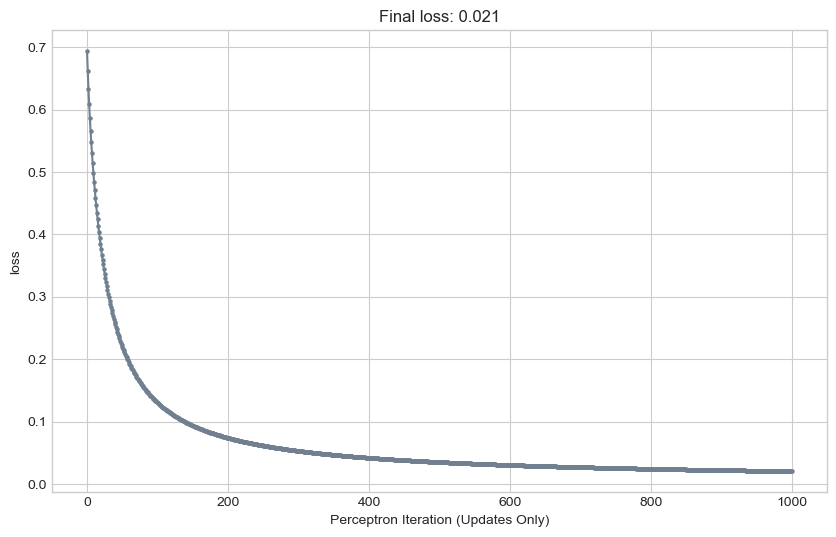

In [34]:
import numpy as np

def plot_loss(loss):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))

    
    plt.plot(loss, color = "slategrey")
    plt.scatter(torch.arange(len(loss)), loss, color = "slategrey", s=5)
    plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
    
    plt.title(f"Final loss: {loss[len(loss)-1]:.3f}")

plot_loss(loss_vec)

We can see that the loss is decreasing monotonically over time through this graph of the loss. The negative slope shows us that the loss is in fact decreasing over time. In other words, our machine learning model is learning!

Plot the final line separating the data

[(-1.0, 2.0), (-1.0, 2.0)]

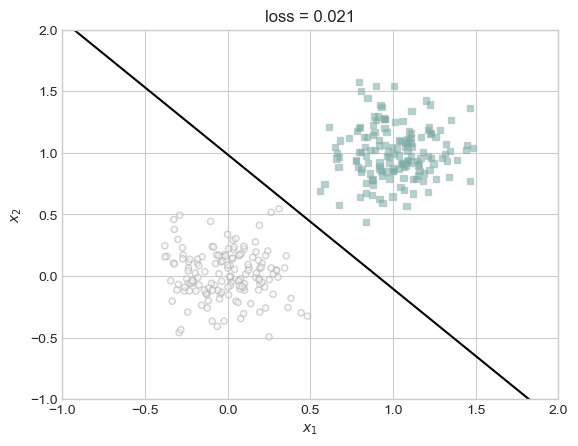

In [35]:
fig, ax = plt.subplots(1, 1)

plot_classification_data(X, y, ax)

draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-1, 2), ylim=(-1, 2))

We can see that the dividing line almost perfectly divides the classes. In time, we could see the logistic regression training could become perfectly accurate.

## Benefits of momentum

Our next experiment was to see the benefits of momentum. On the same data, gradient descent with momentum (e.g. beta=0.9) can converge to the correct weight vector in fewer iterations than vanilla gradient descent (with beta=0).

We want to see: 

1. A model that learns at a faster rate
    * show loss decreasing at a faster rate than when beta was 0

First implement a training loop with graphs with a dividing line to visualize our progress.

In [44]:
# initialize a Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)
X, y = classification_data(noise = 0.2)

# initialize for main loop
loss_vec = []

for index in range(0,1000):
    
    # to see the benefits of momentum, alpha must be sufficiently small and beta must be 0.9
    opt.step(X, y, alpha = 0.3, beta = 0.9)
    loss = LR.loss(X, y).item()            
    loss_vec.append(loss)

Plot the loss over time over the 1000 iterations.

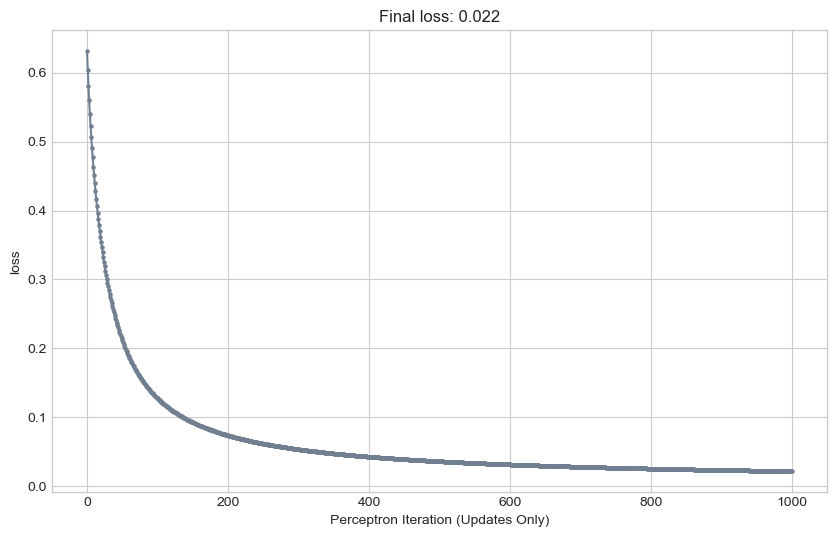

In [45]:
plot_loss(loss_vec)

With the same number of iterations, the final loss is lower. The faster declining slope of the loss shows that the larger beta value does in fact increase the learning speed of the machine learning model. 

[(-1.0, 2.0), (-1.0, 2.0)]

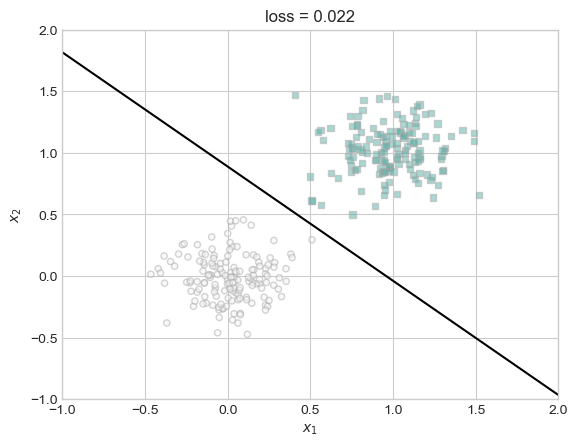

In [46]:
fig, ax = plt.subplots(1, 1)

plot_classification_data(X, y, ax)

draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-1, 2), ylim=(-1, 2))

We can see the benefits of increase of momentum by viewing the improved dividing line. The increase in the beta value allows our logistic regression to improve at a much faster rate then when beta=0. We know that because with the same number of iterations, the loss decreased more, or in other words, the model learned to classify at a faster rate.

In [47]:
find_accuracy(X, y)

Accuracy: 1.0


A perfect accuracy rate!

## Overfitting

Our final experiment was to show the danger of overfitting. To show this I need to generate some data where p_dim > n_points and create an instance where the same logistic regression model has a 100% accuracy rate on training data.

Want to see:

1. Perfect accuracy for training data
2. Less accurate classification for testing data with the exact same parameters

For overfitting, we need to generate data where p_dim > n_points.

In [66]:
X_train, y_train = classification_data(n_points = 50, noise = 0.5, p_dims = 100)

Goal to achieve 100% accuracy with the training data.

In [80]:
# initialize a Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize for main loop
loss_vec = []

for index in range(0,100):
   
    opt.step(X_train, y_train, alpha = 0.1, beta = 0.9)
    loss = LR.loss(X_train, y_train).item()
    loss_vec.append(loss)

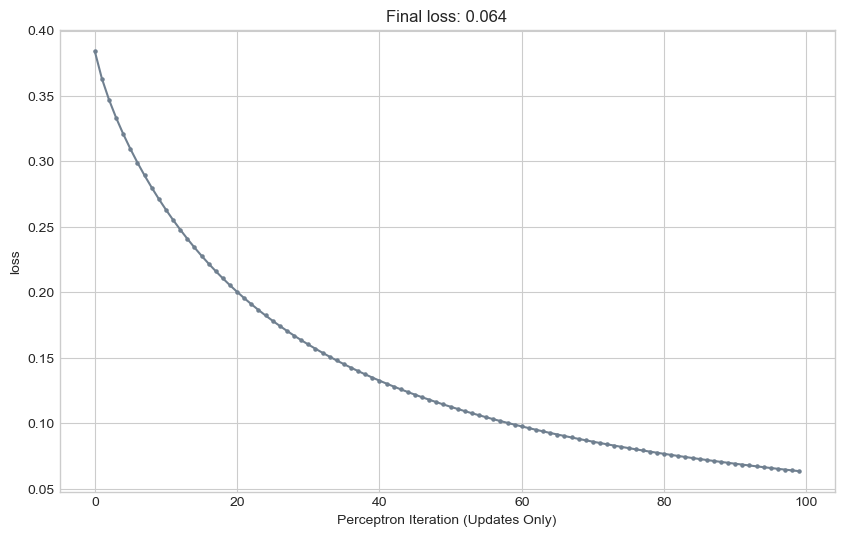

In [81]:
plot_loss(loss_vec)

The logistic regression model has been fit perfectly to the training data.

In [82]:
find_accuracy(X_train, y_train)

Accuracy: 1.0


So we achieved 100% accuracy.

Then we must initialize the test data with the same parameters as the training data.

In [83]:
X_test, y_test = classification_data(n_points = 50, noise = 0.5, p_dims = 100)

In [84]:
find_accuracy(X_test, y_test)

Accuracy: 0.9800000190734863


We can see that the logistic regression model has overfit to the training data and cannot classify the test data with the same accuracy. This it the danger of fitting a model too well to training data, as it is now not generalizable to other data.

## Conclusion

In this blog post, I was able to investigate more about gradient descent and its application in solving the empirical risk minimization problem, specifically focusing on logistic regression. By implementing gradient descent in the logistic regression model, I gained a deeper understanding of how the algorithm works and how it can be customized to suit different classification needs.

Furthermore, I explored a key variant of gradient descent called momentum, which allows logistic regression to achieve faster convergence. Through experiments and analysis, we observed the impact of momentum on the convergence speed on the logistic regression model.

Overall, these experiments taught me valuable lessons in optimization techniques for machine learning models. Through this experience I learned the importance of different parameters though changing the value of beta, and the impact of overfitting on our training data. By combining theory with practical implementation and experimentation, I gained a comprehensive understanding of gradient descent and its variants in the context of logistic regression.

As we continue to learn various machine learning algorithms and optimization techniques, the knowledge and insights gained from this blog post will help me develop practices to build more complex and efficient models in the future.